In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from hockey_rink import NHLRink, RinkImage

Overall Goal: What players were best in xG? This is a great way to evaluate from a hollistic standpoint a players offensive play. If they are rated highly in this category, that means they are taking high quality shots that often result in goals. 

Step 1: Loading in the CSV File

In [194]:
shotData=pd.read_csv("C:\Data Science Practice\shots_2023.csv")

In [154]:
#shotData=shotData[['shotID','arenaAdjustedShotDistance', 'arenaAdjustedXCord', 'arenaAdjustedYCord','averageRestDifference','awayEmptyNet','awaySkatersOnIce','awayTeamCode', 'distanceFromLastEvent','event','game_id','goal','homeEmptyNet','homeSkatersOnIce','homeTeamCode','isPlayoffGame','lastEventCategory','lastEventTeam','lastEventxCord_adjusted','lastEventyCord_adjusted','location','period','shotAngleAdjusted','shotAnglePlusRebound','shotDistance','shotOnEmptyNet','shotRebound','shotRush','shotType','shotWasOnGoal','timeSinceLastEvent','xGoal','team','xCord','yCord','lastEventxCord','lastEventyCord']]

In [195]:
shotData=shotData[['shotID', 'shooterName','shooterPlayerId' ,'shotDistance','timeSinceLastEvent','shotType','speedFromLastEvent','shotAngleAdjusted','shotOnEmptyNet','arenaAdjustedXCord', 'arenaAdjustedYCord', 'goal']]

In [196]:
shotData.head()

,shotID,shooterName,shooterPlayerId,shotDistance,timeSinceLastEvent,shotType,speedFromLastEvent,shotAngleAdjusted,shotOnEmptyNet,arenaAdjustedXCord,arenaAdjustedYCord,goal
0,0,Darren Raddysh,8478178.0,39.698866,3,WRIST,18.678568,40.914383,0,59.0,-26.0,0
1,1,Brayden Point,8478010.0,11.313708,9,TIP,4.499657,45.000000,0,81.0,8.0,0
2,2,Tanner Jeannot,8479661.0,45.343136,11,SNAP,10.948414,41.423666,0,55.0,30.0,0
3,3,Michael Eyssimont,8479591.0,43.139309,32,WRIST,0.662913,44.060809,0,58.0,-30.0,0
4,4,Filip Forsberg,8476887.0,42.201896,19,WRIST,6.831571,53.673174,0,-64.0,34.0,0


Now have our 8 Variables to predict the probability of a goal:
    1) Shot Distance
    2) Time Since last Event
    3) Shot Type
    4) Speed From Last Event
    5) Shot Angle (Adjusted meaning just the maginitude of the angle.)
    6) Shot On Empty Net
    7) X-Cord (Adjusted for arena)
    8) Y-Cord (Adjusted for arena)

In [197]:
#Going to convert all x and y coordinates so that I can have all shots happening on the right side of rink/positive x coordinates
shotData['arenaAdjustedXCord']=np.where(shotData['arenaAdjustedXCord'] < 0, shotData['arenaAdjustedXCord'] * -1, shotData['arenaAdjustedXCord'])
shotData['arenaAdjustedYCord']=np.where(shotData['arenaAdjustedXCord'] < 0, shotData['arenaAdjustedYCord'] * -1, shotData['arenaAdjustedYCord'])
shotData.drop(shotData[shotData['arenaAdjustedXCord'] >89].index, inplace=True)

<Axes: xlabel='arenaAdjustedXCord', ylabel='arenaAdjustedYCord'>

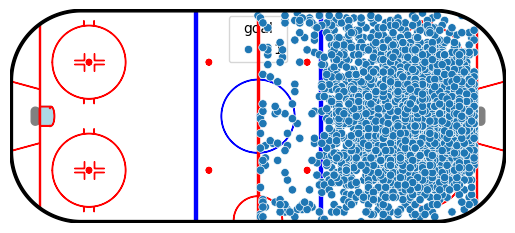

In [198]:
#Going to try to plot scatterplot on top of a rink, to get better visualization (This makes no sense, goals happen from below goal line??? Banks maybe??)
shotDataGoals=shotData[shotData['goal']==1]
rink=NHLRink()
rink.plot_fn(sns.scatterplot,data=shotDataGoals, x="arenaAdjustedXCord", y="arenaAdjustedYCord", hue="goal")

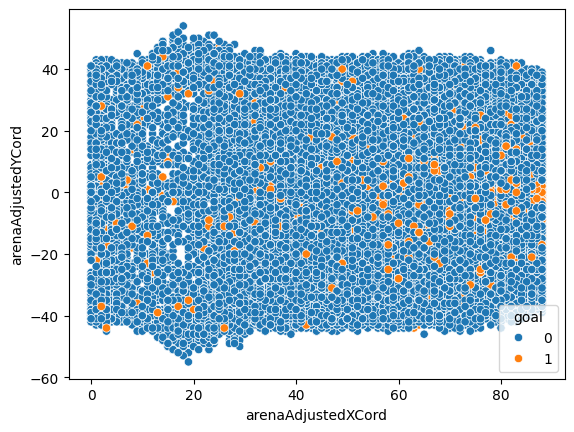

In [199]:
#Going to look at scatterplot to see relationship between xCord and yCord
sns.scatterplot(data=shotData, x="arenaAdjustedXCord", y="arenaAdjustedYCord", hue="goal")
plt.show()

Lets convert shotType to a numerical variable (Lets do one hot encoding, label encoding was terrible) to represent each type of shot, that way we can pass it into a model

In [200]:
#First step load in one hot encoder from the sklearn.preprocessing library
from sklearn.preprocessing import OneHotEncoder
#Second step is to initialize OneHotEncoder
ohe=OneHotEncoder(sparse_output=False, drop='first')
#Third step is to fit and transform
shotData_ohe=ohe.fit_transform(shotData[['shotType']])
#Fourth step is to conver the output to a datafram with the appropriate column names
shotData_df_ohe=pd.DataFrame(shotData_ohe, columns=ohe.get_feature_names_out(['shotType']))
#Fifth step is to combine the encoded shotType columns with the original dataframe
shotData=pd.concat([shotData, shotData_df_ohe], axis=1)


In [201]:
#Just want to see data now
shotData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122426 entries, 0 to 120001
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   shotID              120298 non-null  float64
 1   shooterName         120298 non-null  object 
 2   shooterPlayerId     120298 non-null  float64
 3   shotDistance        120298 non-null  float64
 4   timeSinceLastEvent  120298 non-null  float64
 5   shotType            119287 non-null  object 
 6   speedFromLastEvent  120298 non-null  float64
 7   shotAngleAdjusted   120298 non-null  float64
 8   shotOnEmptyNet      120298 non-null  float64
 9   arenaAdjustedXCord  120298 non-null  float64
 10  arenaAdjustedYCord  120298 non-null  float64
 11  goal                120298 non-null  float64
 12  shotType_DEFL       120298 non-null  float64
 13  shotType_SLAP       120298 non-null  float64
 14  shotType_SNAP       120298 non-null  float64
 15  shotType_TIP        120298 non-null  fl

In [202]:
#Drop all rows that contain na values from shotData
shotData.dropna(inplace=True)
shotData.info()

<class 'pandas.core.frame.DataFrame'>
Index: 117179 entries, 0 to 120297
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   shotID              117179 non-null  float64
 1   shooterName         117179 non-null  object 
 2   shooterPlayerId     117179 non-null  float64
 3   shotDistance        117179 non-null  float64
 4   timeSinceLastEvent  117179 non-null  float64
 5   shotType            117179 non-null  object 
 6   speedFromLastEvent  117179 non-null  float64
 7   shotAngleAdjusted   117179 non-null  float64
 8   shotOnEmptyNet      117179 non-null  float64
 9   arenaAdjustedXCord  117179 non-null  float64
 10  arenaAdjustedYCord  117179 non-null  float64
 11  goal                117179 non-null  float64
 12  shotType_DEFL       117179 non-null  float64
 13  shotType_SLAP       117179 non-null  float64
 14  shotType_SNAP       117179 non-null  float64
 15  shotType_TIP        117179 non-null  fl

In [106]:
# from sklearn.preprocessing import LabelEncoder
# le=LabelEncoder()
# shotData['shotType'] = le.fit_transform(shotData['shotType'])


Now all our variables are numerical, so lets do some EDA. First, see the correlation beteween these variables using correlation matrix

<Axes: >

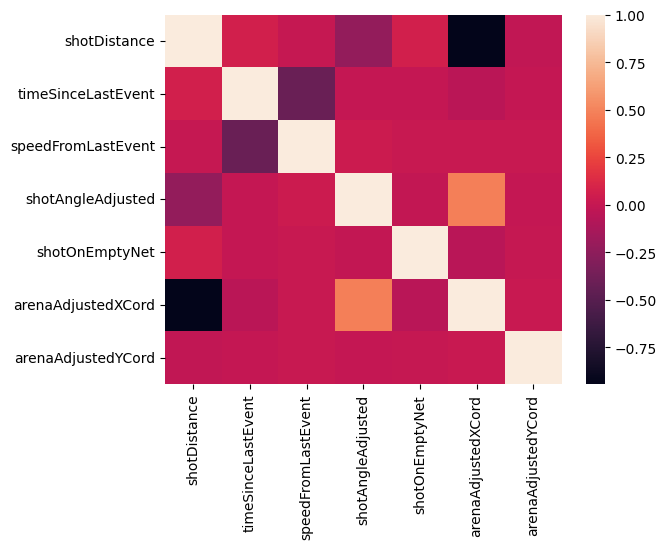

In [203]:
sns.heatmap(shotData[['shotDistance','timeSinceLastEvent','speedFromLastEvent','shotAngleAdjusted','shotOnEmptyNet','arenaAdjustedXCord', 'arenaAdjustedYCord']].corr())

Splitting the data into train and test data. Have to get the independent variables separate from out dependent target variable first

In [204]:
X=shotData[['shotDistance','timeSinceLastEvent','speedFromLastEvent','shotAngleAdjusted','shotOnEmptyNet','arenaAdjustedXCord', 'arenaAdjustedYCord','shotType_DEFL','shotType_SLAP','shotType_SNAP','shotType_TIP','shotType_WRAP','shotType_WRIST']]
y=shotData.goal

In [205]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test= train_test_split(X,y,test_size=0.2, random_state=16)

Fitting Multiple Logistic Regression to the Training Set

In [206]:
from sklearn.linear_model import LogisticRegression
model=LogisticRegression()
model.fit(X_train,y_train)


c:\Data Science Practice\penv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Predicting the test results

In [207]:
y_pred=model.predict(X_test)
y_pred

array([0., 0., 0., ..., 0., 0., 0.])

Calculating the coefficients

In [208]:
print(model.coef_)

[[-8.40597459e-02 -4.40432588e-03 -1.47432427e-02 -4.90260671e-03
   3.93477703e+00 -4.37240929e-02  1.23772688e-03 -1.90629391e-01
   5.84607696e-03  3.19705617e-02  7.43952872e-02  2.79320640e-01
   8.44520327e-02]]


Calculating the Intercept

In [209]:
print(model.intercept_)

[2.84523264]


Evaluating the Model

In [210]:
from sklearn import metrics
score=model.score(X_test,y_test)
score

0.930747567844342

Alright, the model is 93% accurate which is pretty solid. Now I am going to use this model to give the top 25 players for the 2023-24 season in terms of their xG which ultimately evaluates how many goals they were expected to have. This essentially evaluates their number of goals they were expected to have based off their play which is a great way to evaluate a player.

So, we need to load in original data and include the variables shooterName,shooterPlayerId, and shotID. We will merge our predicted xG for each shot back onto the original shotData dataframe. Then group by playerName and playerID, and then take the sum. 

Step 1: for entire dataset, drop the na values, and then use the model to predict probability of goal and bind the prediction onto the end of the dataframe. 

In [211]:
shotData.info() #Believe by looking at this all NA values are dropped. run the model on this dataframe. 

<class 'pandas.core.frame.DataFrame'>
Index: 117179 entries, 0 to 120297
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   shotID              117179 non-null  float64
 1   shooterName         117179 non-null  object 
 2   shooterPlayerId     117179 non-null  float64
 3   shotDistance        117179 non-null  float64
 4   timeSinceLastEvent  117179 non-null  float64
 5   shotType            117179 non-null  object 
 6   speedFromLastEvent  117179 non-null  float64
 7   shotAngleAdjusted   117179 non-null  float64
 8   shotOnEmptyNet      117179 non-null  float64
 9   arenaAdjustedXCord  117179 non-null  float64
 10  arenaAdjustedYCord  117179 non-null  float64
 11  goal                117179 non-null  float64
 12  shotType_DEFL       117179 non-null  float64
 13  shotType_SLAP       117179 non-null  float64
 14  shotType_SNAP       117179 non-null  float64
 15  shotType_TIP        117179 non-null  fl

In [212]:
#Create a variable for all the independent variables
pred_variables= shotData[['shotDistance','timeSinceLastEvent','speedFromLastEvent','shotAngleAdjusted','shotOnEmptyNet','arenaAdjustedXCord', 'arenaAdjustedYCord','shotType_DEFL','shotType_SLAP','shotType_SNAP','shotType_TIP','shotType_WRAP','shotType_WRIST']]
#Get the xG for every shot using the model
xG=model.predict_proba(pred_variables)[:,1]
#Make is a pandas column
shotData['xG']=xG


Now we have the expected goals for each shot taken in the NHL. Lets take a look at the first 10 rows to make sure it looks good

In [213]:
shotData.head(10)

,shotID,shooterName,shooterPlayerId,shotDistance,timeSinceLastEvent,shotType,speedFromLastEvent,shotAngleAdjusted,shotOnEmptyNet,arenaAdjustedXCord,arenaAdjustedYCord,goal,shotType_DEFL,shotType_SLAP,shotType_SNAP,shotType_TIP,shotType_WRAP,shotType_WRIST,shotType_nan,xG
0,0.0,Darren Raddysh,8478178.0,39.698866,3.0,WRIST,18.678568,40.914383,0.0,59.0,-26.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.029072
1,1.0,Brayden Point,8478010.0,11.313708,9.0,TIP,4.499657,45.000000,0.0,81.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.131274
2,2.0,Tanner Jeannot,8479661.0,45.343136,11.0,SNAP,10.948414,41.423666,0.0,55.0,30.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.023777
3,3.0,Michael Eyssimont,8479591.0,43.139309,32.0,WRIST,0.662913,44.060809,0.0,58.0,-30.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.025669
4,4.0,Filip Forsberg,8476887.0,42.201896,19.0,WRIST,6.831571,53.673174,0.0,64.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.021424
5,5.0,Steven Stamkos,8474564.0,19.924859,29.0,SLAP,5.095287,72.474432,0.0,83.0,19.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.047992
6,6.0,Yakov Trenin,8478508.0,20.518285,2.0,SNAP,12.500000,46.974934,0.0,75.0,-15.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.071172
7,7.0,Kiefer Sherwood,8480748.0,48.877398,21.0,SNAP,6.225542,30.762720,0.0,47.0,-25.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.025271
8,8.0,Nicholas Paul,8477426.0,30.413813,13.0,SNAP,5.602725,27.407575,0.0,62.0,-14.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.064054
9,9.0,Victor Hedman,8475167.0,63.134776,4.0,WRIST,15.878445,29.407189,0.0,34.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.014464


Awesome! We now have the expected goals for each shot in our dataframe! Time to groupby player name and Id, and then print out the sum of their expected goals. 

In [217]:
result=shotData.groupby(['shooterName','shooterPlayerId'], as_index=False).sum('xG')
result=result[['shooterPlayerId','shooterName','xG']]
result=result.sort_values('xG', ascending=False)
result.head(20)

,shooterPlayerId,shooterName,xG
907,8475786.0,Zach Hyman,54.817165
77,8479318.0,Auston Matthews,46.241661
770,8477933.0,Sam Reinhart,41.476761
160,8475184.0,Chris Kreider,41.238368
572,8479314.0,Matthew Tkachuk,41.142971
345,8477404.0,Jake Guentzel,40.525586
412,8475166.0,John Tavares,39.425787
102,8480801.0,Brady Tkachuk,39.374732
213,8477956.0,David Pastrnak,38.337903
877,8476389.0,Vincent Trocheck,37.981568
